# Personalization Process


## Importing libraries

In [97]:
import pandas as pd
import numpy as np
import joblib
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from __future__ import print_function

from sklearn.cluster import AgglomerativeClustering

from sklearn.metrics import silhouette_samples, silhouette_score
print(__doc__)
range_n_clusters = [2, 3, 4, 5, 6]

# we are using the scipy implementation
from scipy.spatial.distance import cdist, pdist
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, inconsistent

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
%matplotlib inline

Automatically created module for IPython interactive environment


In [98]:
# define the color palettes
data_colors = ['#a6cdf6','#b2d0b7','#f98ea1', '#ffc0cb', '#800080', '#FFFF00']
background_cmap3 = ListedColormap(['#a6cdf6','#b2d0b7','#f98ea1'])
centroid_colors = ['#1b80e8','#599062','#e20c32','#FF1493', '#800080', '#FFD700' ]
centroid_cmap = ListedColormap(centroid_colors)

## Importing data 

In [194]:
# df = pd.read_csv('/content/sample_data/dataset_project_eHealth20232024.csv')
df = pd.read_csv('../data/dataset_project_eHealth20232024.csv')
random_state = 10
print("datashape: ", df.shape)
print(df.info())
n_samples = df.shape[0]

datashape:  (160, 54)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 54 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        159 non-null    float64
 1   gender     160 non-null    int64  
 2   education  159 non-null    float64
 3   marital    160 non-null    int64  
 4   income     160 non-null    int64  
 5   phq_1      160 non-null    int64  
 6   phq_2      155 non-null    float64
 7   phq_3      159 non-null    float64
 8   phq_4      160 non-null    int64  
 9   phq_5      160 non-null    int64  
 10  phq_6      160 non-null    int64  
 11  phq_7      159 non-null    float64
 12  phq_8      159 non-null    float64
 13  phq_9      159 non-null    float64
 14  gad_1      159 non-null    float64
 15  gad_2      160 non-null    int64  
 16  gad_3      159 non-null    float64
 17  gad_4      159 non-null    float64
 18  gad_5      159 non-null    float64
 19  gad_6      159 non-null    f

## Missing Data & column selection

In [195]:
# Sex and marital status -> average
# df_ccs['age'].fillna(df_ccs.mean()['age'])
# df_ccs['education'].fillna(df_ccs.median()['education'])
df['age'] = df['age'].fillna(df['age'].mean())
df['education'] = df['education'].fillna(df['education'].mean())

columns_to_drop = df.columns[3:29] # Columns 5 to 41
columns_to_drop = columns_to_drop.insert(0, df.columns[1])
# columns_to_drop = columns_to_drop.append(df.columns[1])
# columns_to_drop = df.columns[0:42] # Columns 0 to 41
print(columns_to_drop)
df_ccs = df.drop(columns=columns_to_drop)
# df_ccs = df_ccs.dropna()
# print(df.head())
with pd.option_context('display.max_rows', 10,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(df_ccs)


Index(['gender', 'marital', 'income', 'phq_1', 'phq_2', 'phq_3', 'phq_4',
       'phq_5', 'phq_6', 'phq_7', 'phq_8', 'phq_9', 'gad_1', 'gad_2', 'gad_3',
       'gad_4', 'gad_5', 'gad_6', 'gad_7', 'eheals_1', 'eheals_2', 'eheals_3',
       'eheals_4', 'eheals_5', 'eheals_6', 'eheals_7', 'eheals_8'],
      dtype='object')
      age  education  heas_1  heas_2  heas_3  heas_4  heas_5  heas_6  heas_7  \
0    42.0        5.0     1.0     0.0     0.0       0       0       0       2   
1    51.0       18.0     0.0     1.0     2.0       0       0       2       0   
2    40.0        8.0     0.0     2.0     0.0       0       0       0       0   
3    19.0       25.0     0.0     0.0     3.0       3       3       3       3   
4    42.0       13.0     1.0     0.0     1.0       2       0       0       3   
..    ...        ...     ...     ...     ...     ...     ...     ...     ...   
155  29.0       18.0     3.0     3.0     3.0       2       2       3       3   
156  40.0       13.0     1.0     0.0  

## Features creation

In [196]:
def reverse_score(string, max):
    # print(df_ccs[string])
    mean_value = (max)/2
    df_ccs[string] = df_ccs[string] - mean_value
    df_ccs[string] = - df_ccs[string]
    df_ccs[string] = df_ccs[string] + mean_value
    # print(df_ccs[string])

In [197]:
to_be_reversed = ['ccs_3', 'ccs_6', 'ccs_7', 'ccs_12', 'heas_1', 'heas_2', 'heas_3', 'heas_4', 'heas_5', 'heas_6', 'heas_7',
       'heas_8', 'heas_9', 'heas_10', 'heas_11', 'heas_12', 'heas_13']

for feature in to_be_reversed:
    if feature[:3] == 'ccs':
        reverse_score(feature, 6)
    else:
        reverse_score(feature, 3)

data_ccs = pd.DataFrame() 
data_ccs['Age'] = df_ccs['age']
data_ccs['Education'] = df_ccs['education']
# data_ccs['Education'] = df_ccs['education']
data_ccs['Affective Symptoms'] = df_ccs[['heas_1', 'heas_2', 'heas_3', 'heas_4']].mean(axis=1)
data_ccs['Rumination'] = df_ccs[['heas_5', 'heas_6', 'heas_7']].mean(axis=1)
data_ccs['Behavioural Symptoms'] = df_ccs[['heas_8', 'heas_9', 'heas_10']].mean(axis=1)
data_ccs['Anxiety Personal Impact'] = df_ccs[['heas_11', 'heas_12', 'heas_13']].mean(axis=1)
data_ccs['Attribution Skepticism'] = df_ccs[['ccs_2', 'ccs_6', 'ccs_9']].mean(axis=1)
data_ccs['Impact Skepticism'] = df_ccs[['ccs_3', 'ccs_5', 'ccs_12']].mean(axis=1)
data_ccs['Trend Skepticism'] = df_ccs[['ccs_1', 'ccs_7', 'ccs_11']].mean(axis=1)
data_ccs['Response Skepticism'] = df_ccs[['ccs_4', 'ccs_8', 'ccs_10']].mean(axis=1)
# data_ccs['Income'] = df['income']
'''
dummies = pd.get_dummies(df.gender)
dummies = dummies.replace('True', 1)
dummies = dummies.replace('False', 0)
data_ccs['Male'] = dummies[0]
data_ccs['Female'] = dummies[1]
data_ccs['Non-binary'] = dummies[2]
dummies = pd.get_dummies(df.marital)
dummies = dummies.replace('True', 1)
dummies = dummies.replace('False', 0)
data_ccs['Single'] = dummies[0]
data_ccs['Married'] = dummies[1]
data_ccs['Divorced'] = dummies[2]
data_ccs['Widowed'] = dummies[3]
data_ccs['Separated'] = dummies[4]
'''
print(data_ccs)

final_df = data_ccs.copy()
dummies = pd.get_dummies(df.gender)
dummies = dummies.replace('True', 1)
dummies = dummies.replace('False', 0)
final_df['Male'] = dummies[0]
final_df['Female'] = dummies[1]
final_df['Non-binary'] = dummies[2]
dummies = pd.get_dummies(df.marital)
dummies = dummies.replace('True', 1)
dummies = dummies.replace('False', 0)
final_df['Single'] = dummies[0]
final_df['Married'] = dummies[1]
final_df['Divorced'] = dummies[2]
final_df['Widowed'] = dummies[3]
final_df['Separated'] = dummies[4]
final_df['Income'] = df['income']
#print(final_df)

      Age  Education  Affective Symptoms  Rumination  Behavioural Symptoms  \
0    42.0        5.0                2.75    2.333333              1.666667   
1    51.0       18.0                2.25    2.333333              3.000000   
2    40.0        8.0                2.50    3.000000              3.000000   
3    19.0       25.0                1.50    0.000000              2.333333   
4    42.0       13.0                2.00    2.000000              1.333333   
..    ...        ...                 ...         ...                   ...   
155  29.0       18.0                0.25    0.333333              0.000000   
156  40.0       13.0                1.75    2.000000              1.000000   
157  40.0       13.0                2.25    2.000000              2.666667   
158  41.0        8.0                2.75    2.666667              3.000000   
159  55.0        8.0                2.50    3.000000              3.000000   

     Anxiety Personal Impact  Attribution Skepticism  Impact Sk

In [198]:
# You create a MinMaxScaler object called min_max_scaler. This object will be used to perform the min-max scaling.
# You apply the fit_transform method of the MinMaxScaler to scale the data in the DataFrame df and store the scaled data in np_df.

# EXTRA: The inverse_transform method is used to revert the scaling
# transformation performed by the MinMaxScaler back to the original scale.
# In your code, you are trying to reverse the scaling and obtain the original data.

print(data_ccs)
min_max_scaler = preprocessing.MinMaxScaler()
normalized_data = min_max_scaler.fit_transform(data_ccs)
X_nrm = pd.DataFrame(normalized_data, columns=data_ccs.columns)
# print(X_nrm)

std_scaler = StandardScaler()
standardized_data = std_scaler.fit_transform(data_ccs)
X_std = pd.DataFrame(standardized_data, columns=data_ccs.columns)
#joblib.dump(std_scaler, 'scaler')


      Age  Education  Affective Symptoms  Rumination  Behavioural Symptoms  \
0    42.0        5.0                2.75    2.333333              1.666667   
1    51.0       18.0                2.25    2.333333              3.000000   
2    40.0        8.0                2.50    3.000000              3.000000   
3    19.0       25.0                1.50    0.000000              2.333333   
4    42.0       13.0                2.00    2.000000              1.333333   
..    ...        ...                 ...         ...                   ...   
155  29.0       18.0                0.25    0.333333              0.000000   
156  40.0       13.0                1.75    2.000000              1.000000   
157  40.0       13.0                2.25    2.000000              2.666667   
158  41.0        8.0                2.75    2.666667              3.000000   
159  55.0        8.0                2.50    3.000000              3.000000   

     Anxiety Personal Impact  Attribution Skepticism  Impact Sk

['scaler']

## K-Means

#### Normalized Data

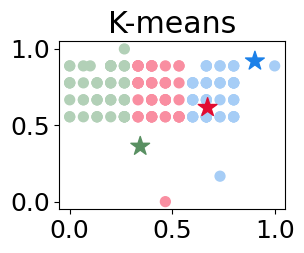

In [199]:
model_nrm = KMeans(n_clusters=3, n_init='auto').fit(X_nrm)
y_pred_nrm = model_nrm.predict(X_nrm)
plt.subplot(221)
plt.scatter(X_nrm['Trend Skepticism'], X_nrm['Response Skepticism'], s=50, c=[data_colors[y] for y in y_pred_nrm])
plt.scatter(model_nrm.cluster_centers_[:,3], model_nrm.cluster_centers_[:,4], marker='*', s=200, c=centroid_colors[:len(model_nrm.cluster_centers_)])
plt.title("K-means")
    
# print(y_pred_nrm)
final_df['Cluster'] = y_pred_nrm
#final_df.to_csv('Nrm_kmeans3_df.csv')
# final_df.to_csv('Nrm_kmeans6_df.csv')

#### Standardized Data

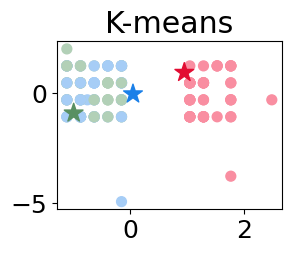

In [200]:
model_std = KMeans(n_clusters=3, n_init='auto').fit(X_std)
y_pred_std = model_std.predict(X_std)
plt.subplot(221)
plt.scatter(X_std['Impact Skepticism'], X_std['Response Skepticism'], s=50, c=[data_colors[y] for y in y_pred_std])
plt.scatter(model_std.cluster_centers_[:,2], model_std.cluster_centers_[:,4], marker='*', s=200, c=centroid_colors[:len(model_std.cluster_centers_)])
plt.title("K-means")


# print(y_pred_nrm)
final_df['Cluster'] = y_pred_nrm
# final_df.to_csv('Std_kmeans3_df.csv')
# final_df.to_csv('Std_kmeans6_df.csv')

#### Knee-elbow analysis

In [201]:
def KneeElbowAnalysis(x,max_k=20):
    k_values = range(2,max_k)
    clusterings = [KMeans(n_clusters=k, random_state=random_state, n_init='auto').fit(x) for k in k_values]
    centroids = [clustering.cluster_centers_ for clustering in clusterings]

    D_k = [cdist(x, cent, 'euclidean') for cent in centroids]
    cIdx = [np.argmin(D,axis=1) for D in D_k]
    dist = [np.min(D,axis=1) for D in D_k]
    avgWithinSS = [sum(d)/x.shape[0] for d in dist]

    # Total with-in sum of square
    wcss = [sum(d**2) for d in dist]

    tss = sum(pdist(x)**2)/x.shape[0]
    bss = tss-wcss

    kIdx = 10-1
    
    #
    # elbow curve
    #
    fig = plt.figure()
    font = {'family' : 'sans', 'size'   : 12}
    plt.rc('font', **font)
    plt.xticks(k_values)
    plt.plot(k_values, wcss, 'o-', color='red', label='WCSS')
    plt.plot(k_values, bss, 'o-', color='blue', label='BCSS')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.legend()
    plt.title('KMeans Clustering');

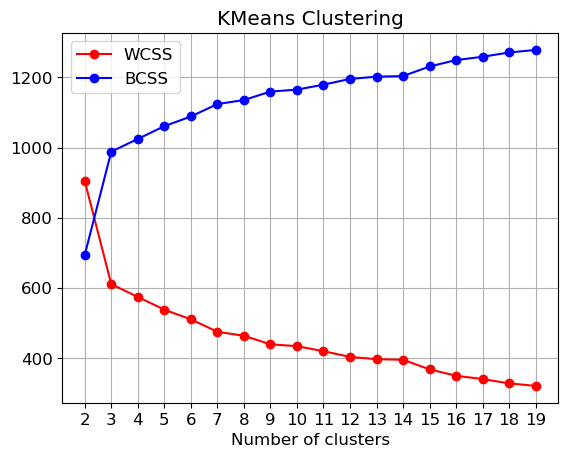

In [202]:
KneeElbowAnalysis(X_std)

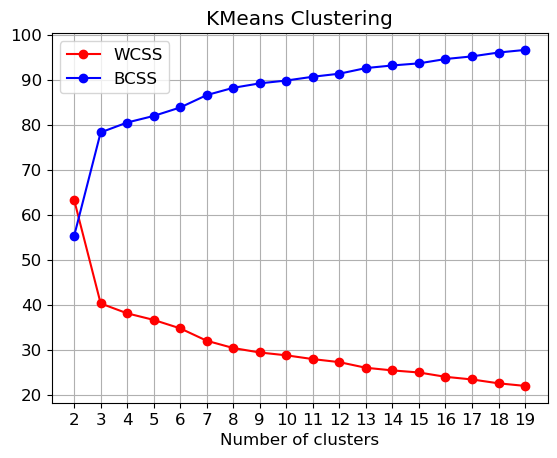

In [203]:
KneeElbowAnalysis(X_nrm)

## Hierarchical Clustering

In [204]:
def plot_dendrogram():
    plt.figure(figsize=(25, 10))
    font = {'family' : 'sans', 'size'   : 18}
    plt.rc('font', **font)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Sample Index')
    plt.ylabel('Distance')
    dendrogram(Z, 
        leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=8.,  # font size for the x axis labels
    ) 
    plt.show()
    """
    dendrogram(
        Z,
        truncate_mode='lastp',  # show only the last p merged clusters
        p=25,  # show only the last p merged clusters
        show_leaf_counts=True,  # otherwise numbers in brackets are counts
        leaf_rotation=90.,
        leaf_font_size=12.,
        show_contracted=False,  # to get a distribution impression in truncated branches
    )
    """
  

In [205]:
def get_inconsistency(d):
    print("\nInconsistency analysis for d = ", d)
    inconsistency = inconsistent(Z, d)
    for i in reversed(range(1,20)):
        print("from %d to %d => Inconsistency %.3f"%(i,i+1,inconsistency[-i][3]))

#### Normalized Data

Z has 159 rows


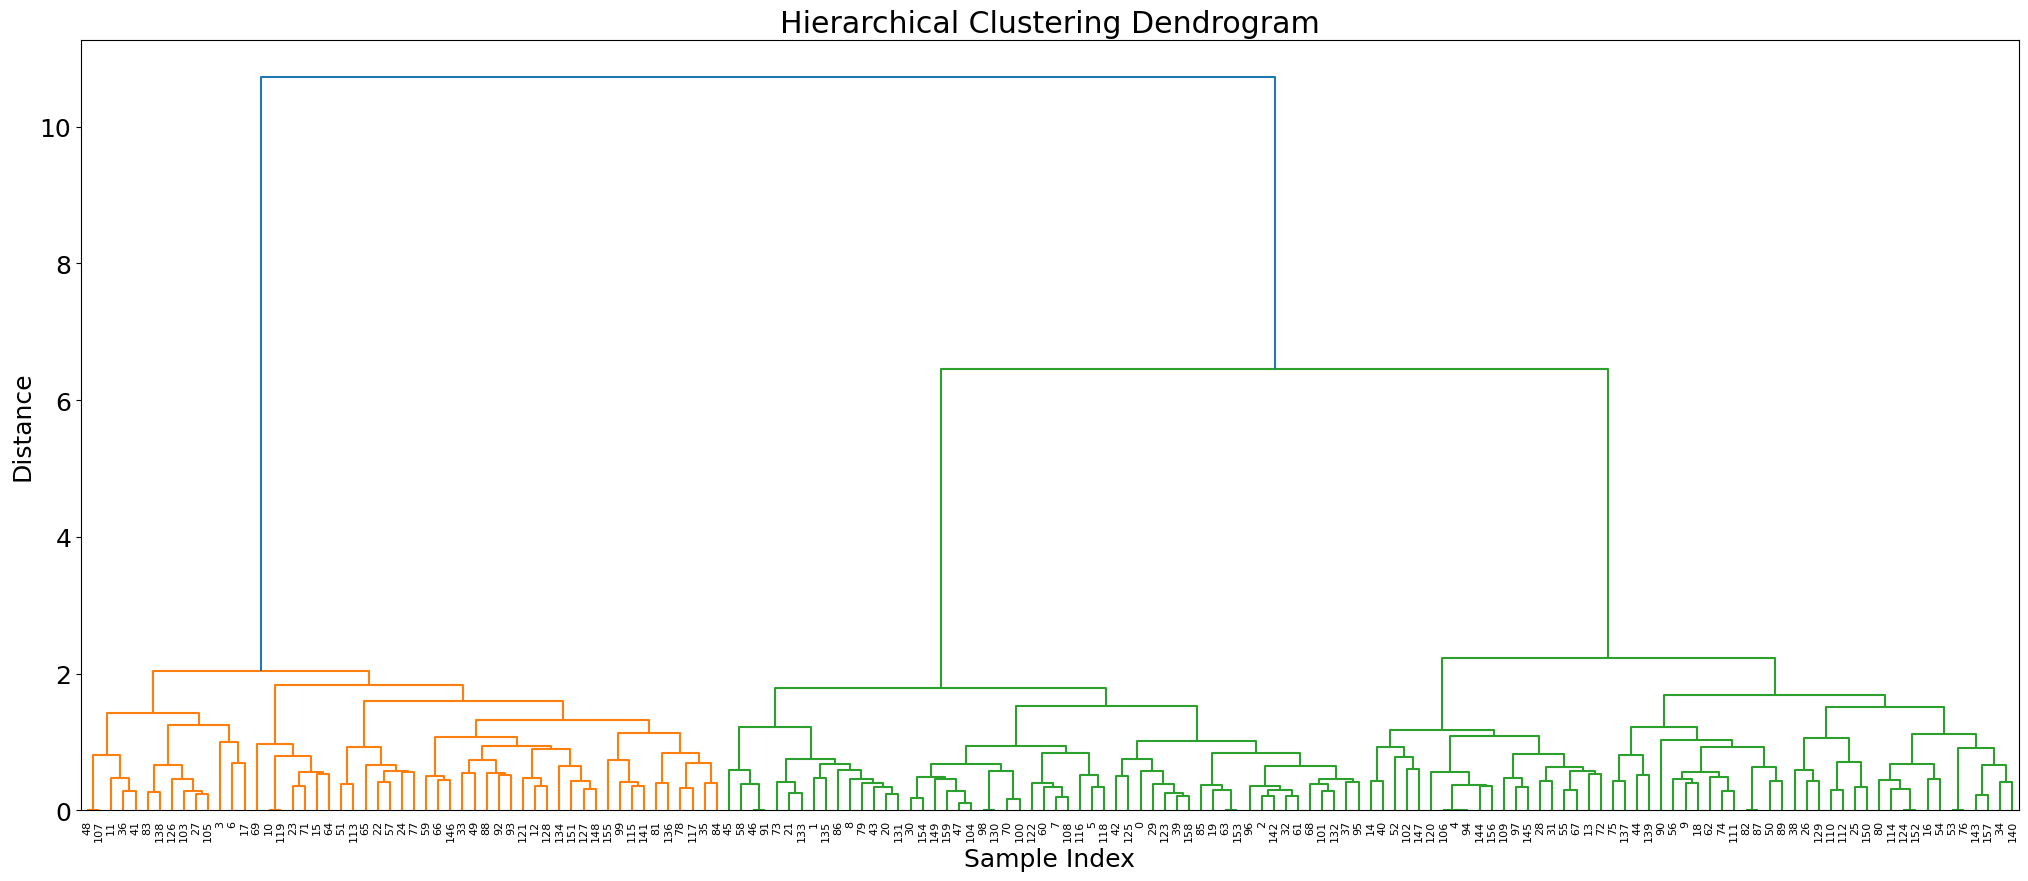


Inconsistency analysis for d =  10
from 19 to 20 => Inconsistency 2.175
from 18 to 19 => Inconsistency 1.821
from 17 to 18 => Inconsistency 1.968
from 16 to 17 => Inconsistency 1.991
from 15 to 16 => Inconsistency 2.561
from 14 to 15 => Inconsistency 1.996
from 13 to 14 => Inconsistency 1.731
from 12 to 13 => Inconsistency 2.498
from 11 to 12 => Inconsistency 1.934
from 10 to 11 => Inconsistency 2.419
from 9 to 10 => Inconsistency 3.552
from 8 to 9 => Inconsistency 3.021
from 7 to 8 => Inconsistency 2.688
from 6 to 7 => Inconsistency 3.754
from 5 to 6 => Inconsistency 3.174
from 4 to 5 => Inconsistency 3.235
from 3 to 4 => Inconsistency 3.763
from 2 to 3 => Inconsistency 8.412
from 1 to 2 => Inconsistency 9.873

Inconsistency analysis for d =  20
from 19 to 20 => Inconsistency 2.175
from 18 to 19 => Inconsistency 1.821
from 17 to 18 => Inconsistency 1.968
from 16 to 17 => Inconsistency 1.991
from 15 to 16 => Inconsistency 2.561
from 14 to 15 => Inconsistency 1.996
from 13 to 14 => Inc

In [206]:
Z = linkage(X_nrm, 'ward')
print('Z has %d rows'%(len(Z)))
plot_dendrogram()
get_inconsistency(10)
get_inconsistency(20)
n_clusters = 7
cluster_labels = []
silhouette_avg = []
for i in range(2, n_clusters):
    cluster_labels.append(fcluster(Z, i, criterion='maxclust'))
    labels, counts = np.unique(cluster_labels[i-2], return_counts=True)
    silhouette_avg.append(silhouette_score(X_nrm, cluster_labels[i-2]))
    print(labels, counts, silhouette_avg[i-2])
    

Normalized_final_df = final_df
# print(cluster_labels[2])
Normalized_final_df['Cluster'] = cluster_labels[1]
Normalized_final_df.to_csv('Normalized_final_df_3clusters.csv')
Normalized_final_df['Cluster'] = cluster_labels[2]
Normalized_final_df.to_csv('Normalized_final_df_4clusters.csv')

#### Standardized Data

Z has 159 rows


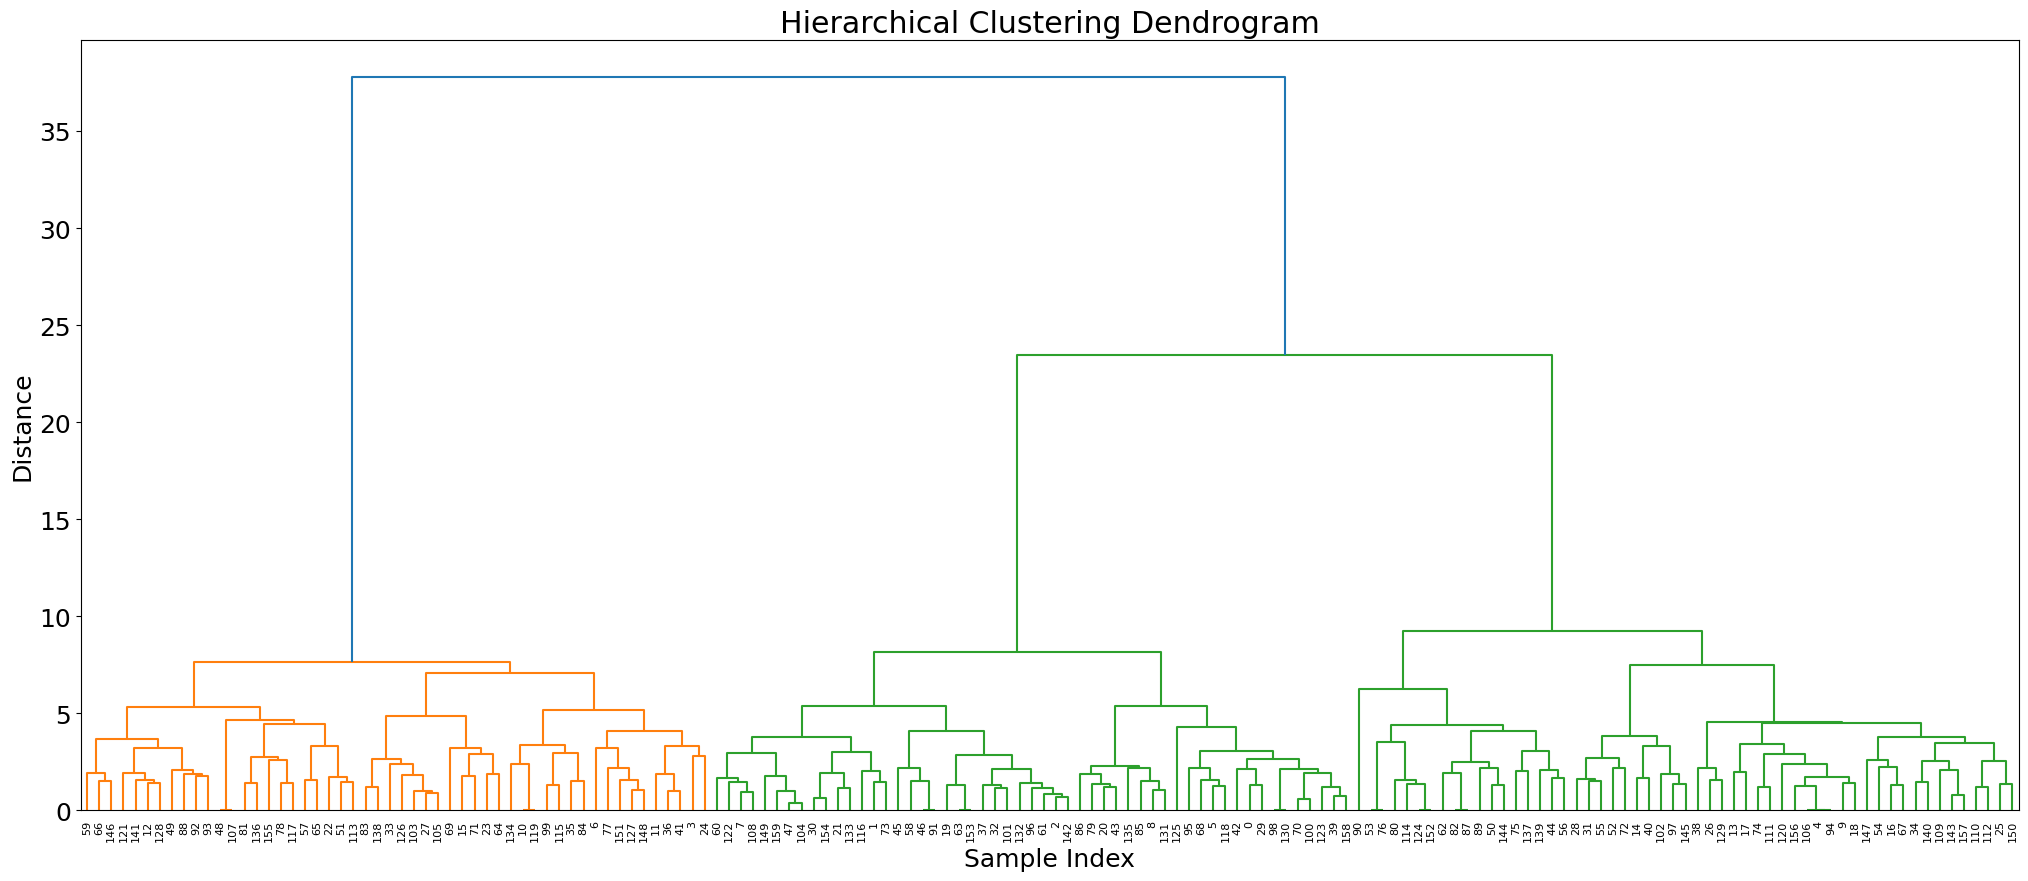


Inconsistency analysis for d =  5
from 19 to 20 => Inconsistency 2.055
from 18 to 19 => Inconsistency 1.798
from 17 to 18 => Inconsistency 2.001
from 16 to 17 => Inconsistency 2.205
from 15 to 16 => Inconsistency 1.789
from 14 to 15 => Inconsistency 1.662
from 13 to 14 => Inconsistency 2.215
from 12 to 13 => Inconsistency 2.083
from 11 to 12 => Inconsistency 2.085
from 10 to 11 => Inconsistency 2.692
from 9 to 10 => Inconsistency 2.598
from 8 to 9 => Inconsistency 2.237
from 7 to 8 => Inconsistency 2.856
from 6 to 7 => Inconsistency 3.101
from 5 to 6 => Inconsistency 2.547
from 4 to 5 => Inconsistency 3.316
from 3 to 4 => Inconsistency 2.795
from 2 to 3 => Inconsistency 4.474
from 1 to 2 => Inconsistency 4.411

Inconsistency analysis for d =  10
from 19 to 20 => Inconsistency 2.286
from 18 to 19 => Inconsistency 1.798
from 17 to 18 => Inconsistency 2.001
from 16 to 17 => Inconsistency 2.178
from 15 to 16 => Inconsistency 2.081
from 14 to 15 => Inconsistency 1.662
from 13 to 14 => Inco

In [207]:
Z = linkage(X_std, 'ward')
print('Z has %d rows'%(len(Z)))
plot_dendrogram()
get_inconsistency(5)
get_inconsistency(10)
n_clusters = 7
cluster_labels = []
silhouette_avg = []
for i in range(2, n_clusters):
    cluster_labels.append(fcluster(Z, i, criterion='maxclust'))
    #print(cluster_labels)
    labels, counts = np.unique(cluster_labels[i-2], return_counts=True)
    silhouette_avg.append(silhouette_score(X_std, cluster_labels[i-2]))
    print(labels, counts, silhouette_avg[i-2])
    
Std_final_df = data_ccs
# print(cluster_labels[2])
Std_final_df['Cluster'] = cluster_labels[1]
Std_final_df.to_csv('Std_final_df_3clusters.csv')
Std_final_df['Cluster'] = cluster_labels[2]
Std_final_df.to_csv('Std_final_df_4clusters.csv')


# Silhouette visualization

### Kmeans silhouette

/Users/caterinagiardi/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/caterinagiardi/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/caterinagiardi/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/caterinagiardi/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default 

For n_clusters = 2 The average silhouette_score is : 0.4098423231029165
For n_clusters = 3 The average silhouette_score is : 0.3784118915292461
For n_clusters = 4 The average silhouette_score is : 0.30913529356968955
For n_clusters = 5 The average silhouette_score is : 0.22519810027174664


/Users/caterinagiardi/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/caterinagiardi/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 6 The average silhouette_score is : 0.24428361903640178
For n_clusters = 7 The average silhouette_score is : 0.15885903424441367


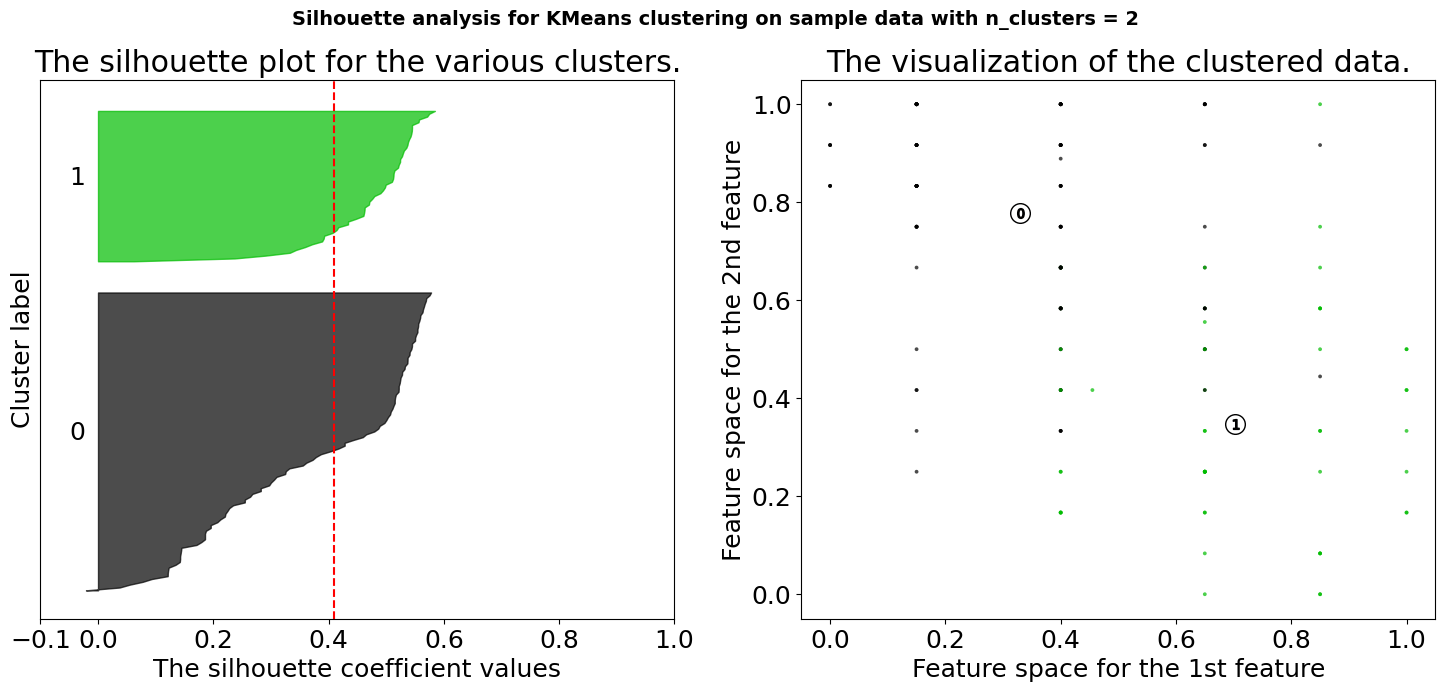

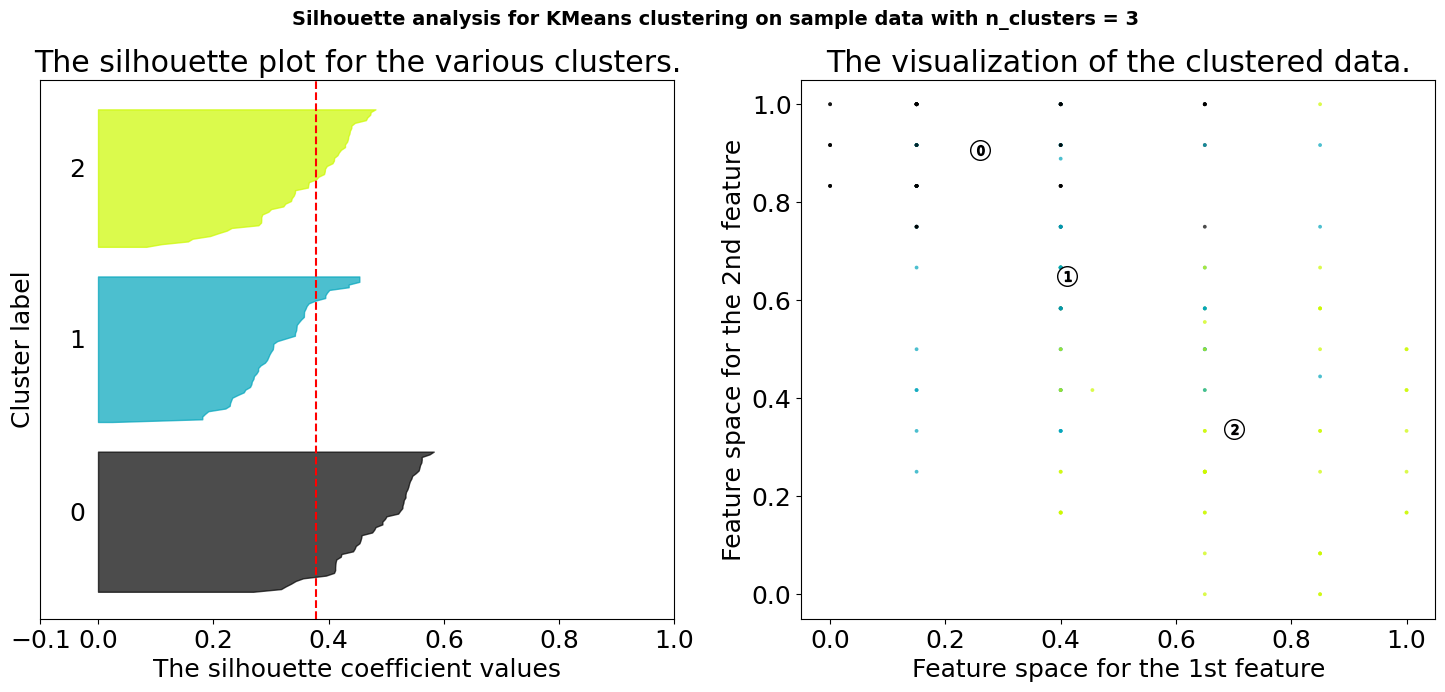

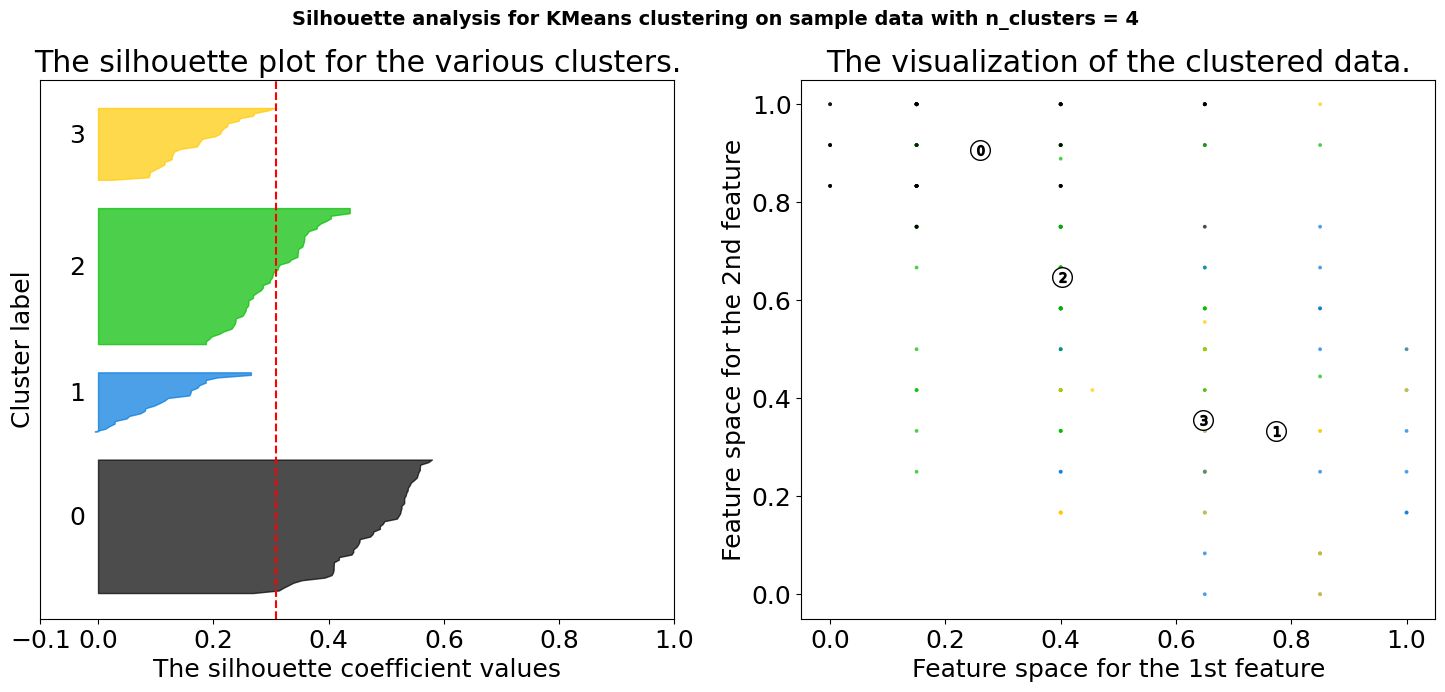

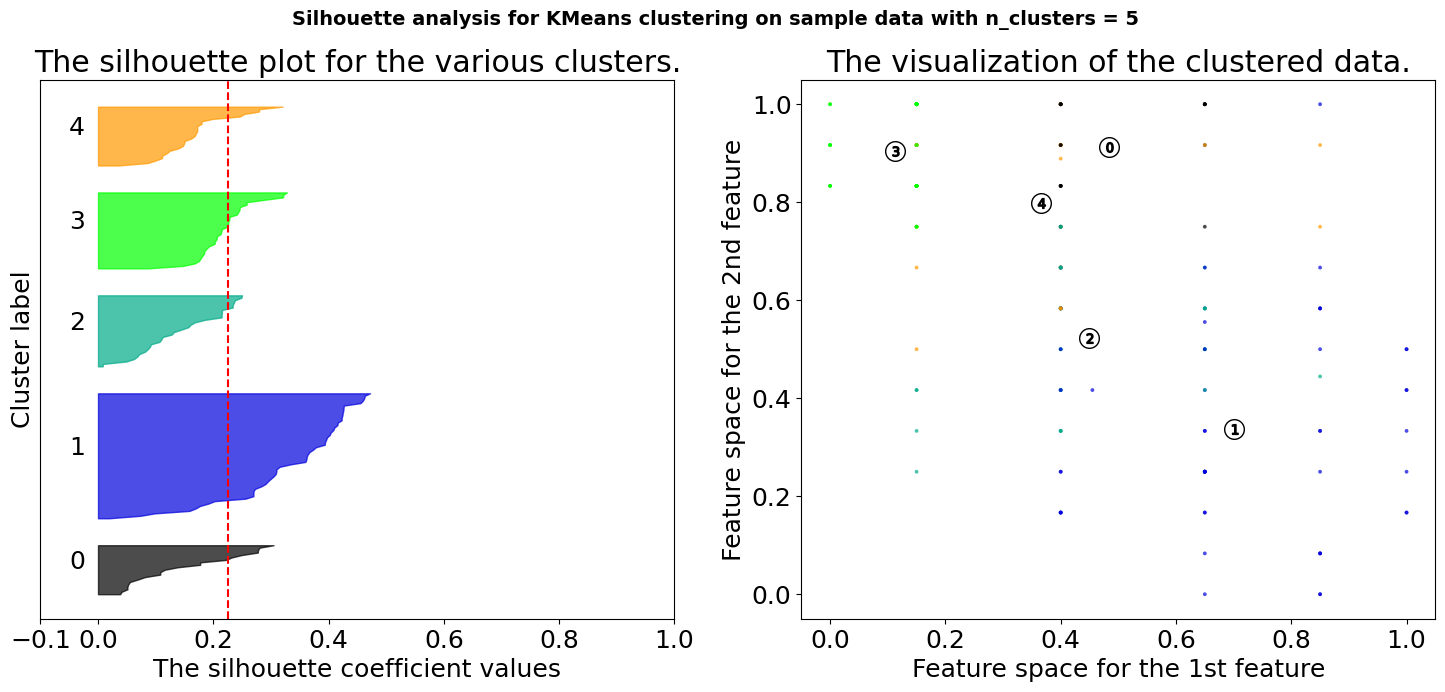

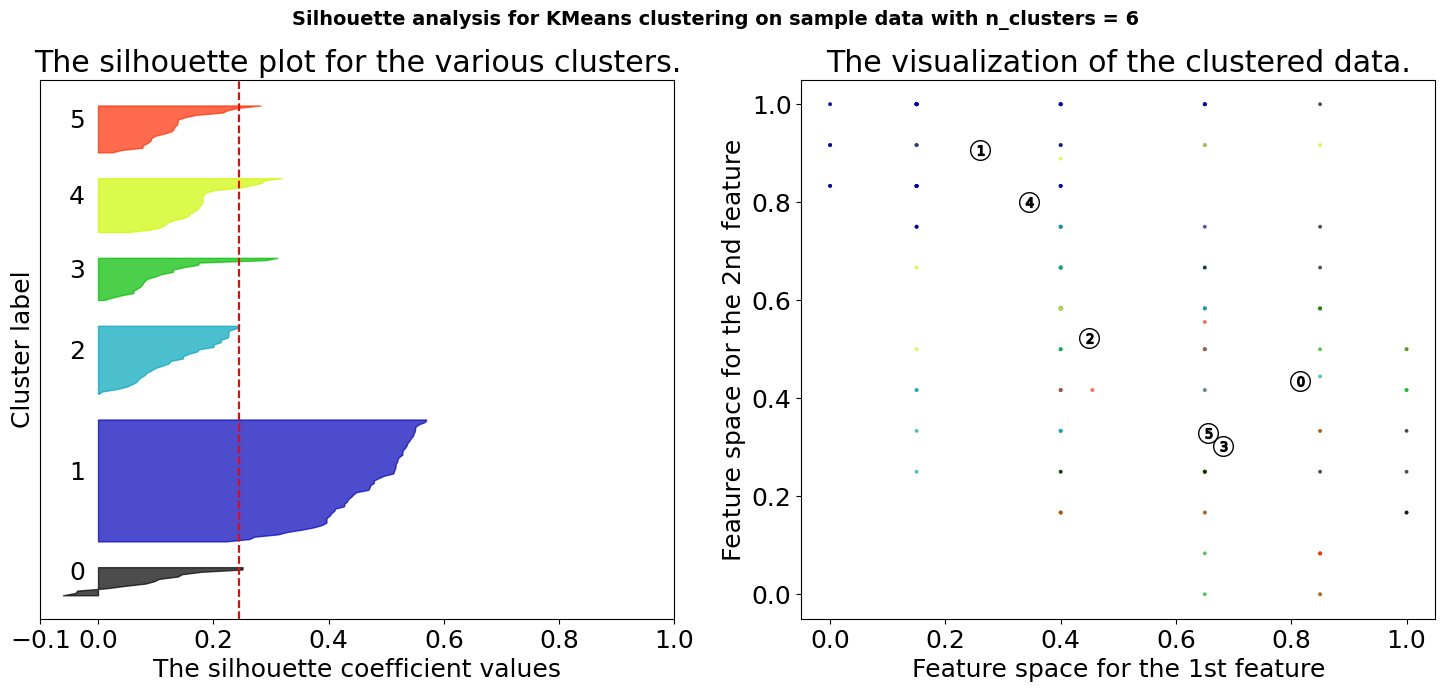

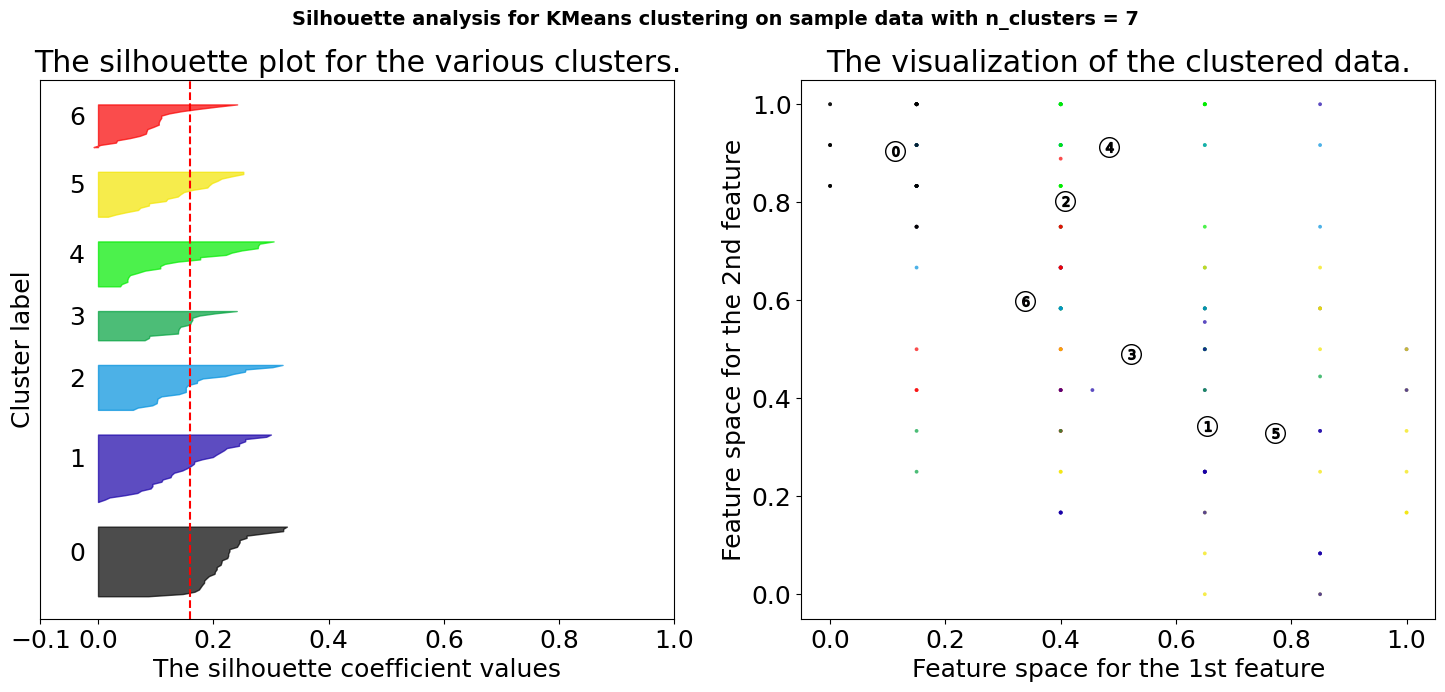

In [208]:
X = X_nrm

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.

range_n_clusters = [2, 3, 4, 5, 6, 7]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X.iloc[:, 1], X.iloc[:, 2], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 1], centers[:, 2], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[1], c[2], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

### New Silhouette agglomerative

In [209]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import numpy as np

In [210]:
range_clusters = [i for i in range(2, 20)]
def Silhouette_Agglomerative(X):
    # Specify the number of clusters
    for n_clusters in range_clusters:

        # Create an AgglomerativeClustering model
        model = AgglomerativeClustering(n_clusters=n_clusters)
        # Fit the model to the data
        model.fit(X)
        # Get cluster labels for each data point
        labels = model.labels_

        # Calculate the silhouette score
        silhouette_avg = silhouette_score(X, labels)

        print(f"Silhouette Score for {n_clusters} : {silhouette_avg}")

In [211]:
Silhouette_Agglomerative(X_std)

Silhouette Score for 2 : 0.3845374338147356
Silhouette Score for 3 : 0.3492613184291839
Silhouette Score for 4 : 0.29679371976360547
Silhouette Score for 5 : 0.21708218155967426
Silhouette Score for 6 : 0.15182119835700186
Silhouette Score for 7 : 0.15336652296953668
Silhouette Score for 8 : 0.15702399908055625
Silhouette Score for 9 : 0.15720991489786487
Silhouette Score for 10 : 0.15309458329458162
Silhouette Score for 11 : 0.15334708844076705
Silhouette Score for 12 : 0.1494719331532038
Silhouette Score for 13 : 0.1510071693333057
Silhouette Score for 14 : 0.15332309924226517
Silhouette Score for 15 : 0.16090915383285515
Silhouette Score for 16 : 0.15520856888679022
Silhouette Score for 17 : 0.14747510979985595
Silhouette Score for 18 : 0.15280764441492348
Silhouette Score for 19 : 0.15286281270341248


In [212]:
Silhouette_Agglomerative(X_nrm)

Silhouette Score for 2 : 0.4118885037062466
Silhouette Score for 3 : 0.3777997965743537
Silhouette Score for 4 : 0.30848229465994725
Silhouette Score for 5 : 0.2418607290149073
Silhouette Score for 6 : 0.2417712336419727
Silhouette Score for 7 : 0.1476000790623216
Silhouette Score for 8 : 0.1473394693426662
Silhouette Score for 9 : 0.14579992530771466
Silhouette Score for 10 : 0.13686962948761566
Silhouette Score for 11 : 0.1396323452390548
Silhouette Score for 12 : 0.14393095222646593
Silhouette Score for 13 : 0.1441726225083774
Silhouette Score for 14 : 0.1450912896708069
Silhouette Score for 15 : 0.14521477261369142
Silhouette Score for 16 : 0.15608315213898633
Silhouette Score for 17 : 0.15289136816333937
Silhouette Score for 18 : 0.15742920629640075
Silhouette Score for 19 : 0.15827299109184848
